In [102]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
#Import data
listings_X = pd.read_csv("data/listings.csv")
#calendar = pd.read_csv("data/calendar.csv")
#neighborhoods = pd.read_csv("data/neighbourhoods.csv")

In [3]:
# First look into the data
listings_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19618 entries, 0 to 19617
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              19618 non-null  int64  
 1   name                            19615 non-null  object 
 2   host_id                         19618 non-null  int64  
 3   host_name                       19091 non-null  object 
 4   neighbourhood_group             19618 non-null  object 
 5   neighbourhood                   19618 non-null  object 
 6   latitude                        19618 non-null  float64
 7   longitude                       19618 non-null  float64
 8   room_type                       19618 non-null  object 
 9   price                           19618 non-null  int64  
 10  minimum_nights                  19618 non-null  int64  
 11  number_of_reviews               19618 non-null  int64  
 12  last_review                     

In [4]:
# Removing variables
listings_X = listings_X.drop(['id', 'name', 'host_name', 'host_id', 'last_review'], axis=1)
listings_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19618 entries, 0 to 19617
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood_group             19618 non-null  object 
 1   neighbourhood                   19618 non-null  object 
 2   latitude                        19618 non-null  float64
 3   longitude                       19618 non-null  float64
 4   room_type                       19618 non-null  object 
 5   price                           19618 non-null  int64  
 6   minimum_nights                  19618 non-null  int64  
 7   number_of_reviews               19618 non-null  int64  
 8   reviews_per_month               13981 non-null  float64
 9   calculated_host_listings_count  19618 non-null  int64  
 10  availability_365                19618 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.6+ MB


In [5]:
print("There are a total of %d neighbourhoods, %d neighbourhood groups and %d room types" % (listings_X.neighbourhood.nunique(),listings_X.neighbourhood_group.nunique(),listings_X.room_type.nunique()))

# Applying one-hot encoding
listings_X = pd.get_dummies(listings_X, columns=['neighbourhood', 'neighbourhood_group', 'room_type'])

There are a total of 128 neighbourhoods, 21 neighbourhood groups and 4 room types


In [6]:
print("The minimum value for the price of any house is %f, so that's the reason why we filter the 0 values" %min(listings_X.price))

#Filtering by price and spliting the dataset into X and Y
listings_X = listings_X[(listings_X['price'] != 0)]
listings_Y = listings_X.price
listings_X.drop(columns=["price"])
listings_X.head()

The minimum value for the price of any house is 0.000000, so that's the reason why we filter the 0 values


,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_Abrantes,neighbourhood_Acacias,...,neighbourhood_group_San Blas - Canillejas,neighbourhood_group_Tetuán,neighbourhood_group_Usera,neighbourhood_group_Vicálvaro,neighbourhood_group_Villa de Vallecas,neighbourhood_group_Villaverde,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,40.45724,-3.67688,60,1,78,0.58,1,180,0,0,...,0,0,0,0,0,0,0,0,1,0
1,40.40381,-3.74130,31,4,33,0.42,2,364,0,0,...,0,0,0,0,0,0,0,0,1,0
2,40.38840,-3.69511,50,15,0,NaN,7,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,40.42183,-3.70529,92,5,10,0.13,1,72,0,0,...,0,0,0,0,0,0,1,0,0,0
4,40.38975,-3.69018,26,2,149,1.12,1,365,0,0,...,0,0,0,0,0,0,0,0,1,0


In [7]:
# Filling NaN values in reviews_per_month column
listings_X.reviews_per_month = listings_X.reviews_per_month.fillna(0)

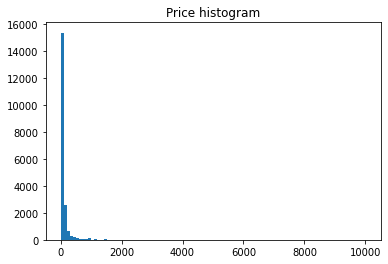

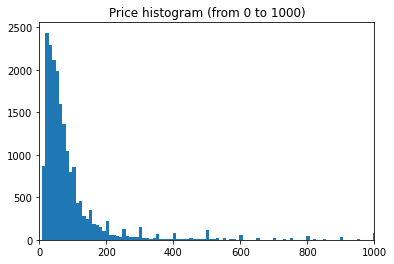

In [8]:
# Analyzing price distribution
plt.hist(listings_Y, bins=100)
plt.title("Price histogram")
plt.show()
plt.title("Price histogram (from 0 to 1000)")
plt.xlim(0,1000)
plt.hist(listings_Y,bins=1000)
plt.show()

In [9]:
# Discretization of "price" column
bins=[0, 50, 200, 500, 1000, 9999]
listings_Y_cat = pd.cut(listings_Y, bins=bins, labels=['Cheap', 'Moderate', 'Pricey', 'Expensive', 'Elite'])
listings_Y_cat.value_counts()

Moderate     9232
Cheap        8648
Pricey       1120
Expensive     382
Elite         228
Name: price, dtype: int64

Number of dimensions before PCA: 161
The number of PC that we get to explain a 99% of variance is 3


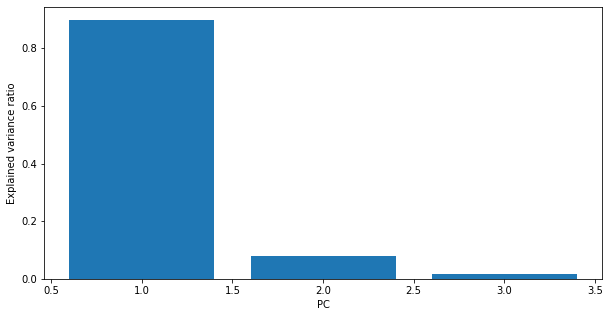

In [10]:
# PCA
print("Number of dimensions before PCA: %d"%listings_X.shape[1])

pca = PCA(n_components=0.99, svd_solver = 'full')
listings_X = pca.fit_transform(listings_X)
print("The number of PC that we get to explain a 99%% of variance is %d" %listings_X.shape[1])

plt.figure(figsize=(10,5))
plt.bar(x = list(range(1,4)), height= pca.explained_variance_ratio_)
plt.ylabel("Explained variance ratio")
plt.xlabel("PC")
plt.show()

In [11]:
#ModelS
lnr = LinearRegression()
lgr = LogisticRegression()
svm = SVC()

In [12]:
#Train/Test Split
splits = [0.05, 0.1, 0.2, 0.5, 0.75]

for split in splits:
    X_train, X_test, y_train, y_test = train_test_split(listings_X, listings_Y, test_size=split)
    X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(listings_X, listings_Y_cat, test_size=split)
    
    lnr.fit(X_train, y_train)
    lgr.fit(X_train_cat, y_train_cat)
    svm.fit(X_train_cat, y_train_cat)
    
    print("LNR Coefficient of Det.: " + str(lnr.score(X_test, y_test)) + " for K = " + str(split))
    print("LGR Mean Accuracy: " + str(lgr.score(X_test_cat, y_test_cat)) + " for K = " + str(split))
    print("SVM Mean Accuracy: " + str(svm.score(X_test_cat, y_test_cat)) + " for K = " + str(split))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LNR Coefficient of Det.: 0.9999999792828057 for K = 0.05
LGR Mean Accuracy: 0.9979612640163099 for K = 0.05
SVM Mean Accuracy: 0.9836901121304791 for K = 0.05


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LNR Coefficient of Det.: 0.9999999931186079 for K = 0.1
LGR Mean Accuracy: 0.9903110657827638 for K = 0.1
SVM Mean Accuracy: 0.9826619071902091 for K = 0.1


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LNR Coefficient of Det.: 0.999999984657573 for K = 0.2
LGR Mean Accuracy: 0.998470168281489 for K = 0.2
SVM Mean Accuracy: 0.9821519632840388 for K = 0.2


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LNR Coefficient of Det.: 0.9999999931170868 for K = 0.5
LGR Mean Accuracy: 0.9959204487506375 for K = 0.5
SVM Mean Accuracy: 0.9783783783783784 for K = 0.5


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LNR Coefficient of Det.: 0.9999999911038829 for K = 0.75
LGR Mean Accuracy: 0.9963285286918684 for K = 0.75
SVM Mean Accuracy: 0.9726679358172423 for K = 0.75


In [13]:
split = .1
X_train, X_test, y_train, y_test = train_test_split(listings_X, listings_Y, test_size=split)
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(listings_X, listings_Y_cat, test_size=split)

In [14]:
# Linear Regression training
lnr.fit(X_train, y_train)

LinearRegression()

In [15]:
# Logistic Regression grid-search
parameters = {'solver': ("newton-cg", "lbfgs", "liblinear", "sag", "saga"), "C":(.5,.75,1,1.25,1.5),"max_iter":(10,100,1000)}
lgr_grid = GridSearchCV(lgr, parameters)
lgr_grid.fit(X_train_cat, y_train_cat)
lgr_grid.best_estimator_

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton

LogisticRegression(C=1, max_iter=1000, solver='newton-cg')

In [16]:
# Support Vector Machine grid-search
parameters = {"kernel":("linear", "poly", "rbf", "sigmoid"), "C":(.5,.75,1,1.25,1.5),"max_iter":(10,100,1000)}
svm_grid = GridSearchCV(svm, parameters)
svm_grid.fit(X_train_cat, y_train_cat)
svm_grid.best_estimator_

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Py

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Pyt

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Pytho

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=10).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python

SVC(C=1.5, kernel='linear', max_iter=1000)

In [96]:
#Evalutation/Graphs

#lnr classification report
coeff_of_det = lnr.score(X_test, y_test)
lnr_pred = lnr.predict(X_test)
bins=[0, 50, 200, 500, 1000, 99999]
labels = [1, 2, 3, 4, 5]
lnr_predict_cat = pd.cut(lnr_pred, bins=bins, labels=labels)
lnr_true_cat = pd.cut(y_test, bins=bins, labels=labels)
print(lnr_predict_cat.to_numpy())
print(lnr_true_cat.to_numpy())
#print(np.any(np.isnan(y_test)))
print(classification_report(lnr_true_cat.to_numpy(), lnr_predict_cat.to_numpy(), target_names=['Cheap', 'Moderate', 'Pricey', 'Expensive', 'Elite']))

[1 2 5 ... 2 1 2]
[1 2 5 ... 2 1 2]
              precision    recall  f1-score   support

       Cheap       1.00      0.99      0.99       881
    Moderate       0.99      1.00      0.99       927
      Pricey       0.99      0.98      0.98        92
   Expensive       0.95      1.00      0.98        42
       Elite       1.00      1.00      1.00        19

    accuracy                           0.99      1961
   macro avg       0.99      0.99      0.99      1961
weighted avg       0.99      0.99      0.99      1961



(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Cheap'),
  Text(1, 0, 'Moderate'),
  Text(2, 0, 'Pricey'),
  Text(3, 0, 'Expensive'),
  Text(4, 0, 'Elite')])

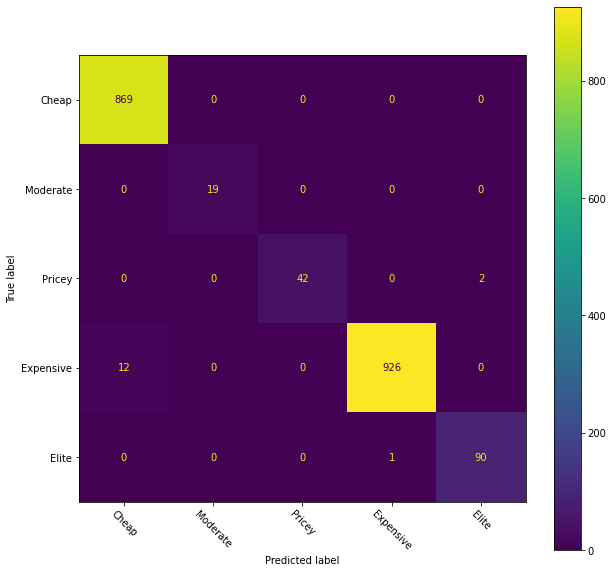

In [105]:
#lnr confusion matrix
labels = ['Cheap', 'Moderate', 'Pricey', 'Expensive', 'Elite']
lnr_predict_cat = pd.cut(lnr_pred, bins=bins, labels=labels)
lnr_true_cat = pd.cut(y_test, bins=bins, labels=labels)

fig, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(lnr_predict_cat, lnr_true_cat)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=labels)
disp.plot(ax=ax)
plt.xticks(rotation = -45)

In [106]:
#lgr classification report
lgr_predict_cat = lgr_grid.predict(X_test_cat)
print(classification_report(y_test_cat, lgr_predict_cat, target_names=['Cheap', 'Moderate', 'Pricey', 'Expensive', 'Elite']))

              precision    recall  f1-score   support

       Cheap       1.00      1.00      1.00       904
    Moderate       1.00      1.00      1.00        26
      Pricey       1.00      1.00      1.00        34
   Expensive       1.00      1.00      1.00       877
       Elite       1.00      1.00      1.00       120

    accuracy                           1.00      1961
   macro avg       1.00      1.00      1.00      1961
weighted avg       1.00      1.00      1.00      1961



C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Cheap'),
  Text(1, 0, 'Elite'),
  Text(2, 0, 'Expensive'),
  Text(3, 0, 'Moderate'),
  Text(4, 0, 'Pricey')])

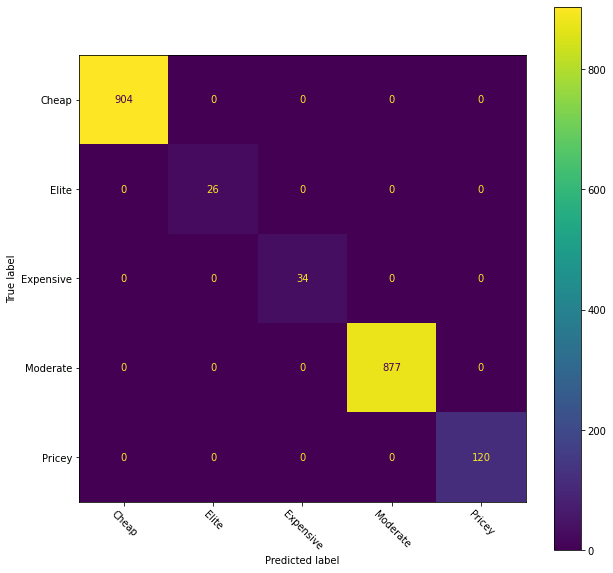

In [41]:
#lgr prediction confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(lgr_grid, X_test_cat, y_test_cat, ax=ax)
plt.xticks(rotation = -45)

In [107]:
#svm classification report
svm_predict_cat = svm_grid.predict(X_test_cat)
print(classification_report(y_test_cat, svm_predict_cat, target_names=['Cheap', 'Moderate', 'Pricey', 'Expensive', 'Elite']))

              precision    recall  f1-score   support

       Cheap       1.00      1.00      1.00       904
    Moderate       1.00      1.00      1.00        26
      Pricey       1.00      1.00      1.00        34
   Expensive       1.00      0.98      0.99       877
       Elite       0.89      0.98      0.93       120

    accuracy                           0.99      1961
   macro avg       0.98      0.99      0.98      1961
weighted avg       0.99      0.99      0.99      1961



C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Cheap'),
  Text(1, 0, 'Elite'),
  Text(2, 0, 'Expensive'),
  Text(3, 0, 'Moderate'),
  Text(4, 0, 'Pricey')])

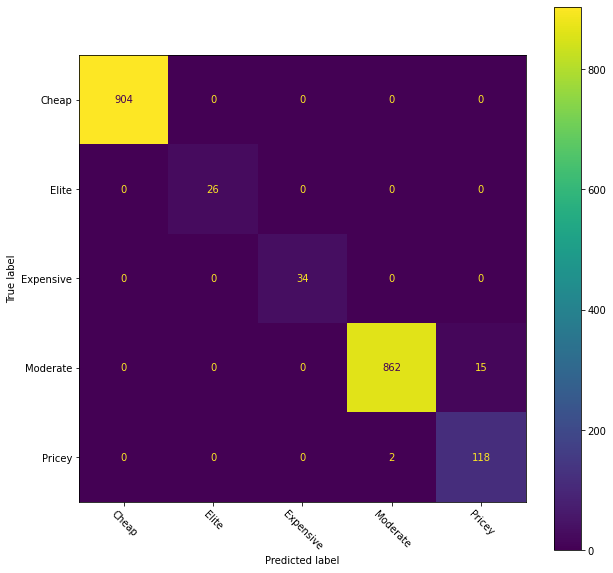

In [40]:
#svm prediction confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(svm_grid, X_test_cat, y_test_cat, ax=ax)
plt.xticks(rotation = -45)